#**Importation des bibliothèques**

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

# Télécharger les données NLTK nécessaires (à exécuter une seule fois)
nltk.download('stopwords')

# Rendre les graphiques plus esthétiques
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Chargement des données**

In [41]:
from datasets import load_dataset

# Charger le dataset
dataset = load_dataset("dbarbedillo/SMS_Spam_Multilingual_Collection_Dataset")

# Obtenir les noms des colonnes originales
original_columns = dataset["train"].column_names

# Sélectionner uniquement les colonnes des textes en français et labels (ham/spam)
# Et supprimer toutes les autres colonnes d'origine
fr_data = dataset["train"].map(lambda x: {"text": x["text_fr"], "labels": x["labels"]}, remove_columns=original_columns)

# Retirer les entrées vides
fr_data = fr_data.filter(lambda x: x["text"] is not None and x["text"].strip() != "")

# Vérifier
print(len(fr_data))

# Afficher les 5 premiers exemples
for i in range(5):
    print(fr_data[i])
    print("-" * 50)

5572
{'labels': 'ham', 'text': "Allez jusqu'à Jurong point, fou.. Disponible seulement dans bugis n grand monde la e buffet... Cine il y a eu plus..."}
--------------------------------------------------
{'labels': 'ham', 'text': "J'ai fait une blague sur le wif u oni..."}
--------------------------------------------------
{'labels': 'spam', 'text': "Entrée libre dans 2 a wkly comp pour gagner FA Cup final tkts 21 mai 2005. Texte FA à 87121 pour recevoir la question d'entrée(std txt rate)T&C's appliquer 08452810075over18's"}
--------------------------------------------------
{'labels': 'ham', 'text': 'U dun dit si tôt hor... U c déjà dire alors...'}
--------------------------------------------------
{'labels': 'ham', 'text': "Non, je ne pense pas qu'il va à usf, il vit dans le coin."}
--------------------------------------------------


# **Analyse exploratoire des données (AED)**

labels
ham     4825
spam     747
Name: count, dtype: int64


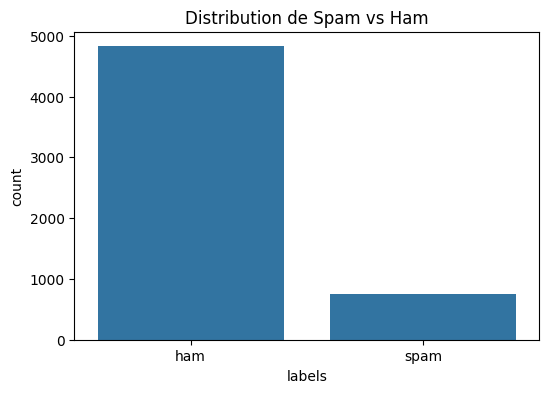

In [42]:
import pandas as pd

# Convertir le dataset en DataFrame pandas pour une manipulation plus facile
fr_data_df = fr_data.to_pandas()

print(fr_data_df['labels'].value_counts())

# Visualiser la distribution
plt.figure(figsize=(6,4))
sns.countplot(x='labels', data=fr_data_df)
plt.title("Distribution de Spam vs Ham")
plt.show()

# **Ingénierie des caractéristiques :**

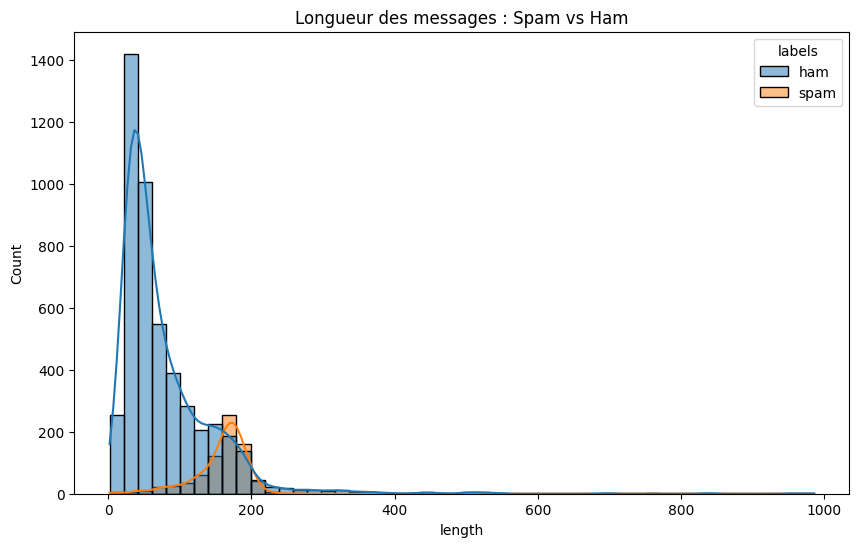

In [43]:
# Créer une nouvelle colonne 'length' (longueur du message)
fr_data_df['length'] = fr_data_df['text'].apply(len)

# Tracer la distribution
plt.figure(figsize=(10,6))
sns.histplot(data=fr_data_df, x='length', hue='labels', bins=50, kde=True)
plt.title("Longueur des messages : Spam vs Ham")
plt.show()

#**Normalisation**


In [44]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", " ", text)        # Supprimer les URLs
    text = re.sub(r"\S+@\S+", " ", text)        # Supprimer les adresses e-mail
    text = re.sub(r"\d+", " ", text)            # Supprimer les nombres
    text = re.sub(r"[^\w\s]", " ", text)        # Supprimer la ponctuation
    text = re.sub(r"\s+", " ", text).strip()    # Supprimer les espaces multiples et les espaces en début/fin
    return text

fr_data_df["clean_text"] = fr_data_df["text"].apply(clean_text)

fr_data_df[["text", "clean_text"]].head()

,text,clean_text
0,"Allez jusqu'à Jurong point, fou.. Disponible s...",allez jusqu à jurong point fou disponible seul...
1,J'ai fait une blague sur le wif u oni...,j ai fait une blague sur le wif u oni
2,Entrée libre dans 2 a wkly comp pour gagner FA...,entrée libre dans a wkly comp pour gagner fa c...
3,U dun dit si tôt hor... U c déjà dire alors...,u dun dit si tôt hor u c déjà dire alors
4,"Non, je ne pense pas qu'il va à usf, il vit da...",non je ne pense pas qu il va à usf il vit dans...


In [45]:
from sklearn.model_selection import train_test_split

X = fr_data_df["clean_text"]
y = fr_data_df["labels"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Taille de l'ensemble d'entraînement:", X_train.shape[0])
print("Taille de l'ensemble de test :", X_test.shape[0])

Taille de l'ensemble d'entraînement: 4457
Taille de l'ensemble de test : 1115


# **Vectorisation** : TF-IDF + N-GRAM

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

# Obtenir les mots vides français de NLTK
french_stop_words = stopwords.words('french')

tfidf = TfidfVectorizer(
    ngram_range=(1, 2),      # unigram + bigram
    min_df=2,
    max_df=0.9,
    stop_words=french_stop_words # Utiliser la liste des mots vides français
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("Forme TF-IDF entraînement:", X_train_tfidf.shape)
print("Forme TF-IDF test :", X_test_tfidf.shape)

Forme TF-IDF entraînement: (4457, 7914)
Forme TF-IDF test : (1115, 7914)


Il est préférable de maintenir l'ordre actuel des opérations, où les données sont d'abord divisées en ensembles d'entraînement et de test, puis la vectorisation TF-IDF est appliquée. Cette approche est cruciale pour éviter la fuite de données (data leakage).

Si nous vectorisions l'ensemble du dataset avant de le diviser, le modèle TF-IDF apprendrait du vocabulaire et des fréquences de termes à partir des données de test, ce qui compromettrait l'intégrité de l'évaluation du modèle. La méthode actuelle, où tfidf.fit_transform() est appliquée sur X_train et tfidf.transform() sur X_test, garantit que le modèle ne voit les données de test qu'au moment de l'évaluation, ce qui donne une mesure plus fiable de ses performances.

Définition du modèle et Entrainement

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Instancier le modèle de classificateur Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Entraîner le modèle
rf_model.fit(X_train_tfidf, y_train)

# Prédire sur l'ensemble de test
y_pred_rf = rf_model.predict(X_test_tfidf)

# Calculer la précision (Accuracy) pour Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Précision (Random Forest): {accuracy_rf:.4f}")

# Calculer le score F1 pour Random Forest (moyenne pondérée pour les classes déséquilibrées)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
print(f"Score F1: {f1_rf:.4f}")

Précision (Random Forest): 0.9767
Score F1: 0.9757


Vérification de la performance avec matrice de confusion

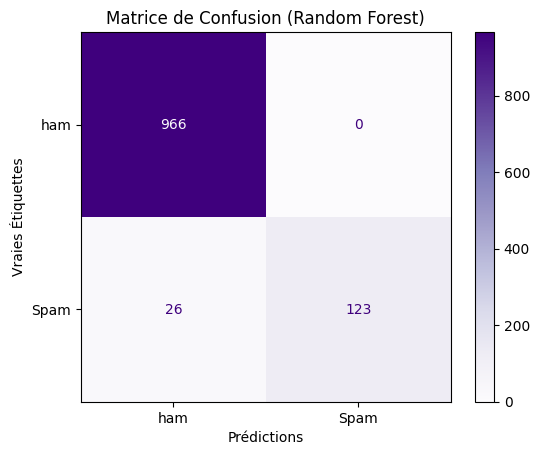

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Définir les étiquettes en français
french_labels = ['ham', 'Spam']

# Calculer la matrice de confusion pour Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=rf_model.classes_)

# Afficher la matrice de confusion avec les étiquettes françaises et les labels d'axes
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=french_labels)
disp_rf.plot(cmap=plt.cm.Purples) # Utilisation d'une autre colormap pour la distinction
plt.title("Matrice de Confusion (Random Forest)")
plt.xlabel("Prédictions")
plt.ylabel("Vraies Étiquettes")
plt.show()

Test

In [49]:
import numpy as np

def predict_spam_ham_rf(message):
    # Nettoyer le message en utilisant la fonction clean_text définie précédemment
    clean_msg = clean_text(message)

    # Transformer le message nettoyé en utilisant le vectoriseur TF-IDF ajusté
    # tfidf a été défini dans la cellule TenJ5rUl8zWD
    message_vector = tfidf.transform([clean_msg])

    # Prédire les probabilités en utilisant le modèle Random Forest entraîné
    # rf_model a été défini dans la cellule 03fa15ca
    probabilities = rf_model.predict_proba(message_vector)

    # Obtenir les étiquettes de classe
    class_labels = rf_model.classes_

    # Trouver l'indice de la classe avec la plus haute probabilité
    max_prob_idx = np.argmax(probabilities[0])

    # Obtenir l'étiquette prédite et sa confiance
    predicted_label = class_labels[max_prob_idx]
    confidence = probabilities[0][max_prob_idx] * 100

    return f"{predicted_label}: {confidence:.2f}%"

# Tester avec des messages personnalisés en utilisant le modèle Random Forest
print("\n--- Test réel avec Random Forest ---")

input_message_rf_1 = "Félicitations! Vous avez gagné une carte cadeau de 1000 euros. Appelez maintenant pour réclamer."
prediction_rf_1 = predict_spam_ham_rf(input_message_rf_1)
print(f"Message test: '{input_message_rf_1}'")
print(f"Prédiction (Random Forest): {prediction_rf_1}")

input_message_rf_2 = "URGENT – Problème de sécurité sur votre compte.Cher client,Nous avons détecté une activité suspecte sur votre compte bancaire.Veuillez confirmer vos informations immédiatement pour éviter la suspension.👉 Cliquez ici : www.securite-compte-verif.com"
prediction_rf_2 = predict_spam_ham_rf(input_message_rf_2)
print(f"Message test: '{input_message_rf_2}'")
print(f"Prédiction (Random Forest): {prediction_rf_2}")

input_message_rf_3 = "Rendez-vous à 14h pour notre réunion."
prediction_rf_3 = predict_spam_ham_rf(input_message_rf_3)
print(f"Message test: '{input_message_rf_3}'")
print(f"Prédiction (Random Forest): {prediction_rf_3}")


--- Test réel avec Random Forest ---
Message test: 'Félicitations! Vous avez gagné une carte cadeau de 1000 euros. Appelez maintenant pour réclamer.'
Prédiction (Random Forest): spam: 75.00%
Message test: 'URGENT – Problème de sécurité sur votre compte.Cher client,Nous avons détecté une activité suspecte sur votre compte bancaire.Veuillez confirmer vos informations immédiatement pour éviter la suspension.👉 Cliquez ici : www.securite-compte-verif.com'
Prédiction (Random Forest): spam: 76.00%
Message test: 'Rendez-vous à 14h pour notre réunion.'
Prédiction (Random Forest): ham: 100.00%


Creation du fichier Pickkle

In [50]:
import pickle

# Sauvegarder le vectoriseur TF-IDF
with open('vectorisation_TF_IDF.pkl', 'wb') as file:
    pickle.dump(tfidf, file)
print("Vectoriseur TF-IDF sauvegardé sous vectorisation_TF_IDF.pkl")

# Sauvegarder le modèle Random Forest
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)
print("Modèle Random Forest sauvegardé sous random_forest_model.pkl")

Vectoriseur TF-IDF sauvegardé sous vectorisation_TF_IDF.pkl
Modèle Random Forest sauvegardé sous random_forest_model.pkl
